# Distance Analysis: spleen-codex-ufl

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `spleen-codex-ufl` dataset.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "spleen-codex-ufl"
data_filedir = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir)
output_edge_dir = os.path.join("data-processed-edges", dataset_dir)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
df_all_nodes, df_all_edges, df_all_edges_with_cell_types = read_all_edge_datasets(basepath, data_filedir, output_edge_dir)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,0.0,3403.933,Macrophages,macrophage,macrophage,CL:0000235,skos:exactMatch,macrophage,macrophage,CL:0000235,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,FSLD
1,0.0,3356.808,Sinusoidal cells,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,FSLD
2,0.0,3313.830,Sinusoidal cells,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,FSLD
3,0.0,3304.405,indistinct,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,FSLD
4,0.0,3281.031,indistinct,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,FSLD


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 12
Level Three Cell Type: 12
Level Two Cell Type: 9
Level One Cell Type: 3


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - blood endothelial

Level Three Cell Type:
  - endothelial cell of sinusoid
  - endothelial cell of lymphatic vessel
  - endothelial cell of vascular tree

Level Two Cell Type:
  - endothelial cell of sinusoid
  - endothelial cell of lymphatic vessel
  - endothelial cell of vascular tree

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell of sinusoid', # Choosing sinusoid due to high number of instances in the dataset compared to other endothelial cell types.
    'Level Two Cell Type': 'endothelial cell of sinusoid',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,0.0,3403.933,Macrophages,macrophage,macrophage,CL:0000235,skos:exactMatch,macrophage,macrophage,CL:0000235,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,FSLD
1,0.0,3356.808,Sinusoidal cells,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,FSLD
2,0.0,3313.830,Sinusoidal cells,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell of sinusoid,endothelial cell of sinusoid,CL:0002262,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,FSLD
3,0.0,3304.405,indistinct,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,FSLD
4,0.0,3281.031,indistinct,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,FSLD


In [12]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Dataset" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Dataset']
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].map(region_map)
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].str.split('-').str[1].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,FSLD,FSLD
1,FSLD,FSLD
2,FSLD,FSLD
3,FSLD,FSLD
4,FSLD,FSLD


In [13]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['FSLD' 'KSFB' 'NGPL' 'PBVN' 'PKHL' 'XXCD']
Total number of unique regions: 6

Number of unique datasets per unique region:
FSLD: 1
KSFB: 1
NGPL: 1
PBVN: 1
PKHL: 1
XXCD: 1


## Process datasets to add region information to Edges files.

In [14]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level
0,0,0.000,3403.933,0,9.425,3409.211,0,10.802218,FSLD,endothelial cell of sinusoid,Level Three Cell Type
1,24,1.131,3416.374,0,9.425,3409.211,0,10.958969,FSLD,endothelial cell of sinusoid,Level Three Cell Type
2,43,12.818,3415.620,0,9.425,3409.211,0,7.251740,FSLD,endothelial cell of sinusoid,Level Three Cell Type
3,95,21.866,3407.703,0,9.425,3409.211,0,12.532061,FSLD,endothelial cell of sinusoid,Level Three Cell Type
4,115,22.997,3415.997,0,9.425,3409.211,0,15.173957,FSLD,endothelial cell of sinusoid,Level Three Cell Type


In [15]:
# Process the edge data to create new columns "Unique Region" based on the "Dataset" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Dataset']
# df_all_edges['Unique Region'] = df_all_edges['Dataset'].map(region_map)


# Check if the new columns are created correctly.
df_all_edges[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,FSLD,FSLD
1,FSLD,FSLD
2,FSLD,FSLD
3,FSLD,FSLD
4,FSLD,FSLD


In [16]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['FSLD' 'KSFB' 'NGPL' 'PBVN' 'PKHL' 'XXCD']
Total number of unique regions: 6

Number of unique datasets per unique region:
FSLD: 1
KSFB: 1
NGPL: 1
PBVN: 1
PKHL: 1
XXCD: 1


In [17]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset']
# df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,FSLD,FSLD
1,FSLD,FSLD
2,FSLD,FSLD
3,FSLD,FSLD
4,FSLD,FSLD


In [18]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Unique Region
0,0.0,3403.933,Macrophages,macrophage,macrophage,CL:0000235,skos:exactMatch,macrophage,macrophage,CL:0000235,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,FSLD,FSLD


In [19]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Unique Region
0,0,0.0,3403.933,0,9.425,3409.211,0,10.802218,FSLD,endothelial cell of sinusoid,Level Three Cell Type,FSLD


In [20]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Unique Region
0,0,0.0,3403.933,0,9.425,3409.211,0,10.802218,FSLD,endothelial cell of sinusoid,Level Three Cell Type,macrophage,macrophage,immune cell,FSLD


## Node Analysis

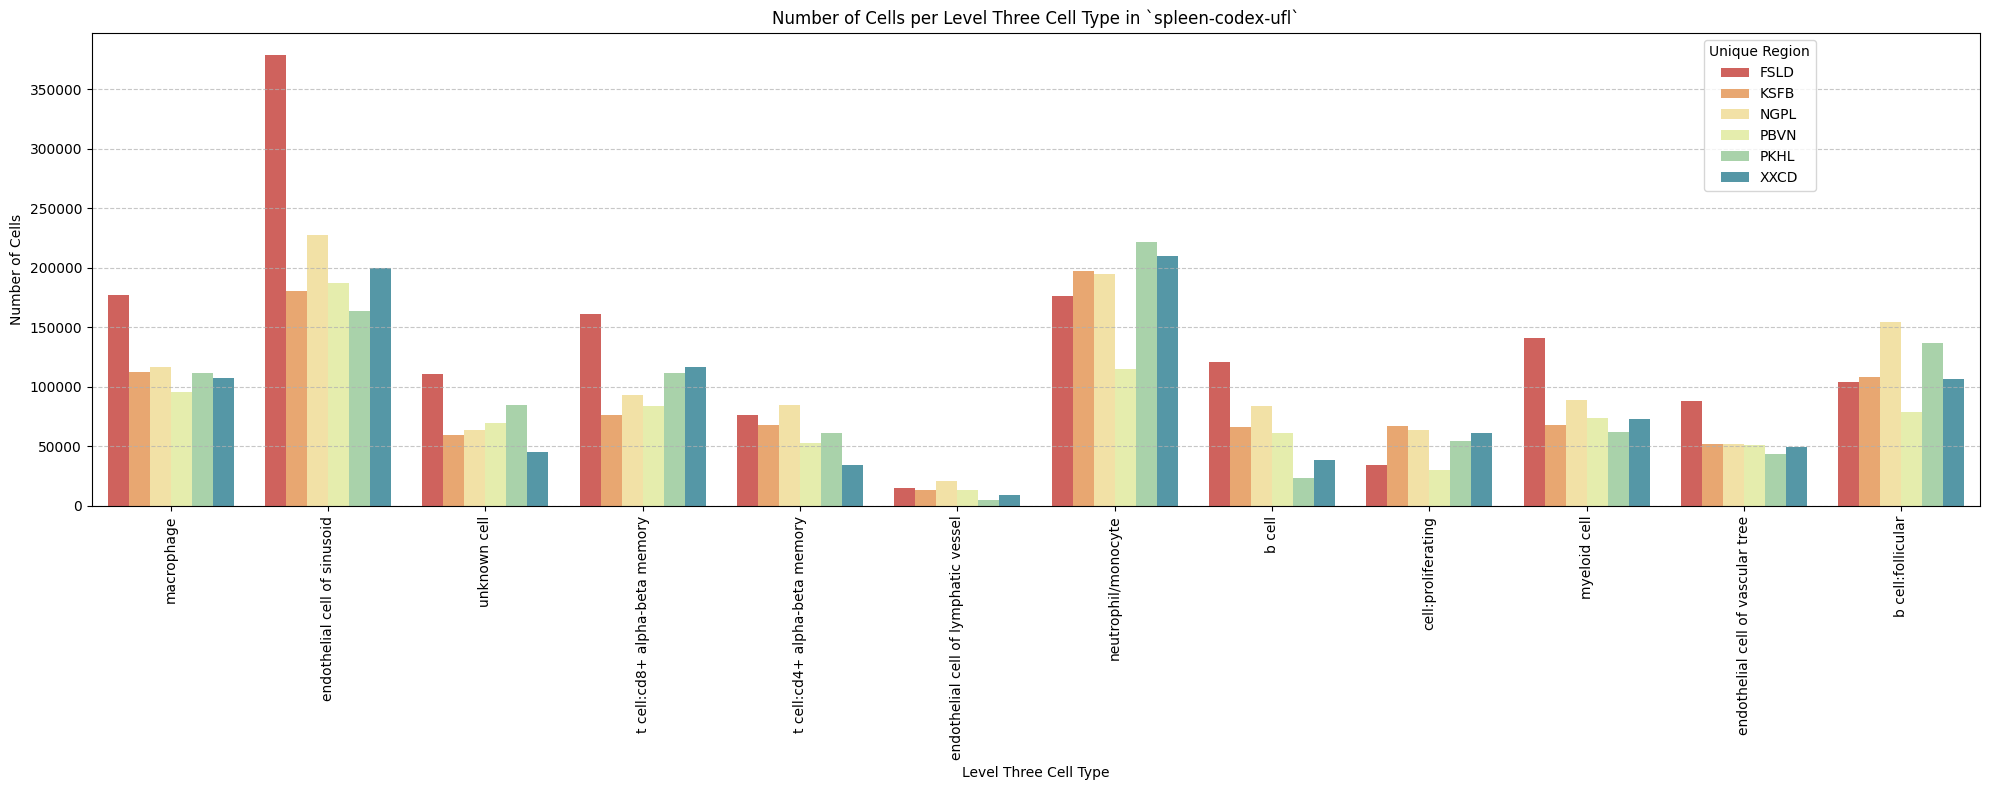

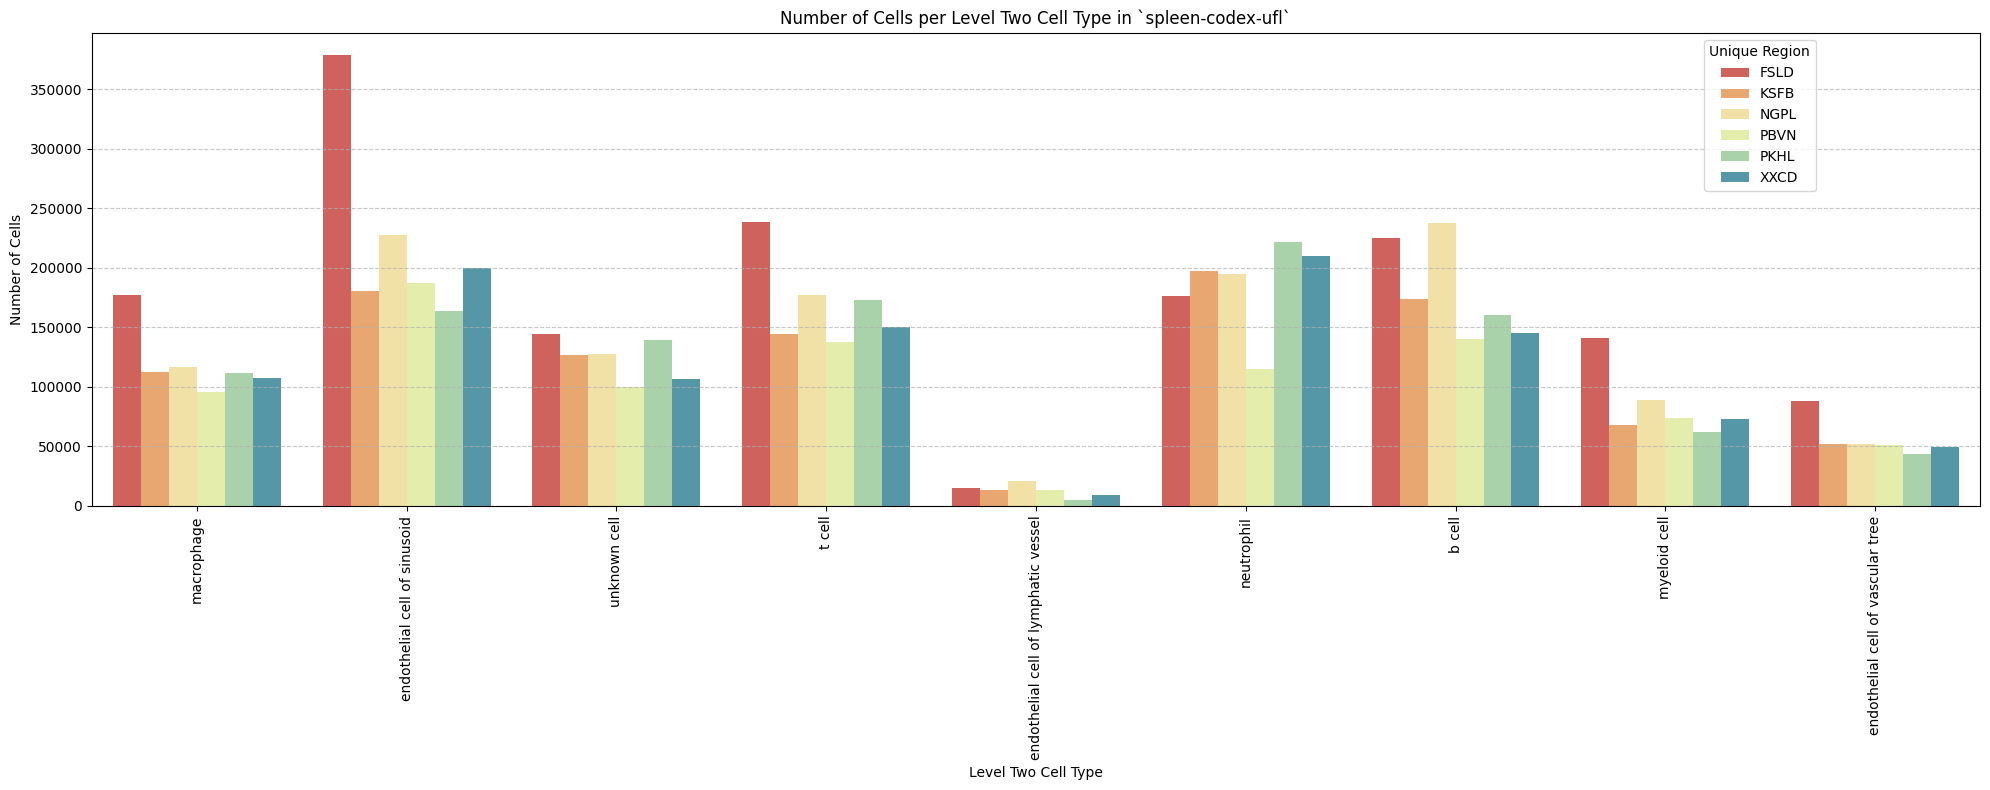

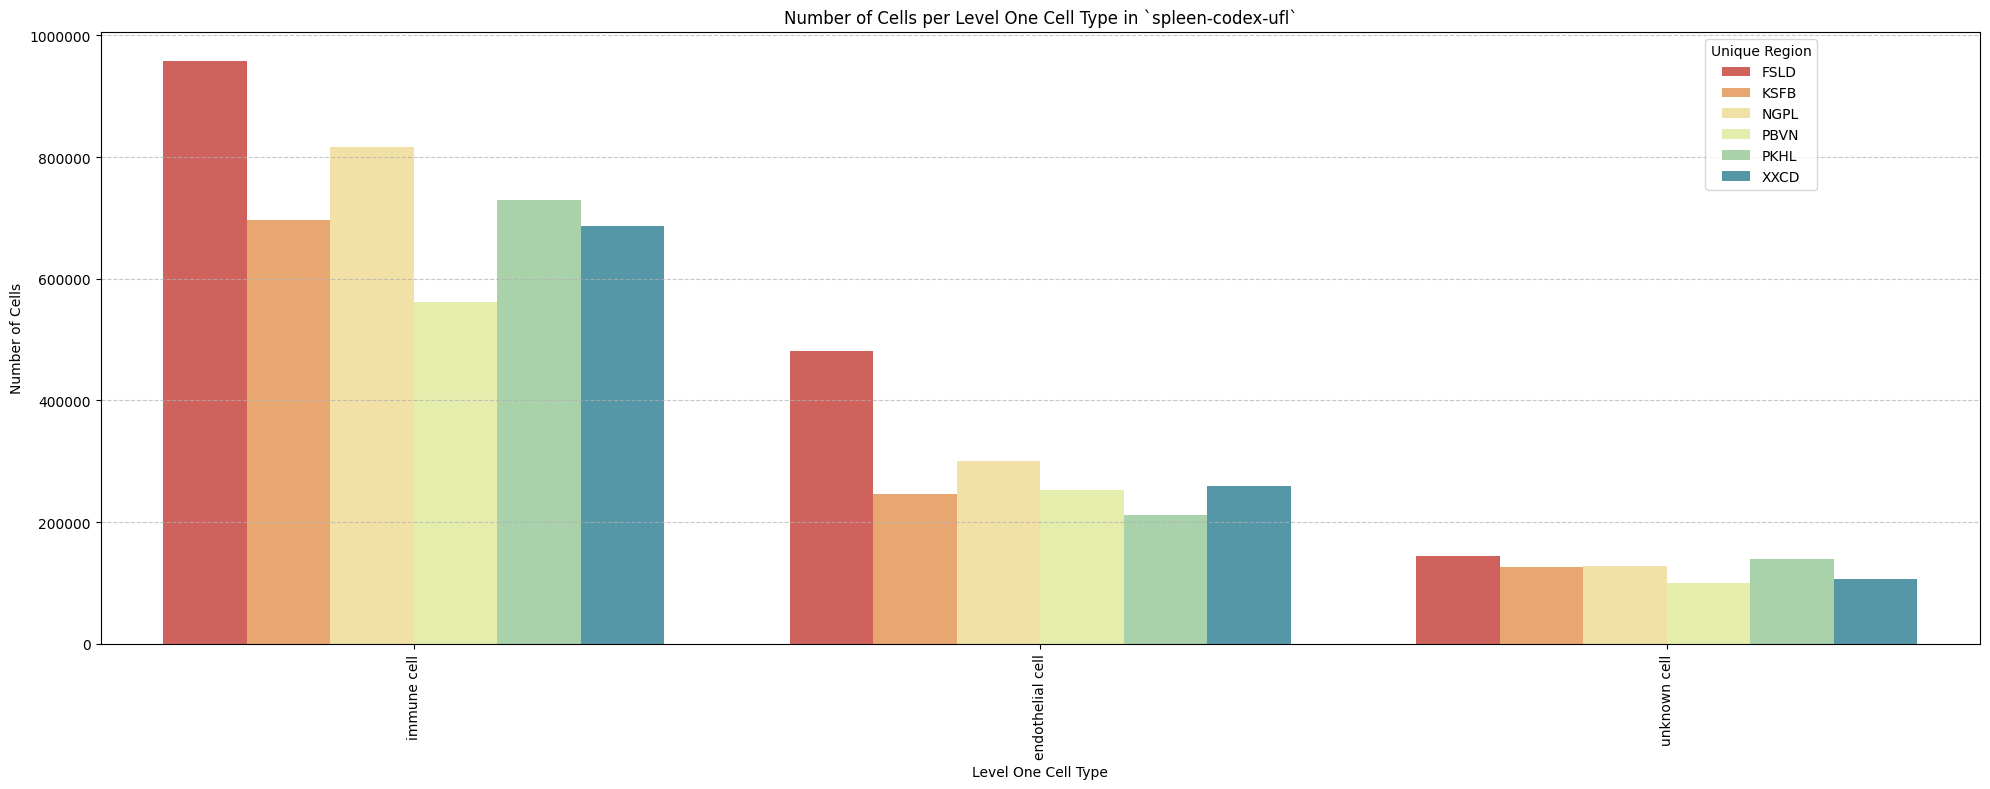

In [21]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [22]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,FSLD,endothelial cell,Level One Cell Type,11.933050,10.185979,0.377000,120.663560
1,FSLD,endothelial cell of lymphatic vessel,Level Three Cell Type,69.140742,62.332820,0.377000,199.993437
2,FSLD,endothelial cell of lymphatic vessel,Level Two Cell Type,69.140742,62.332820,0.377000,199.993437
3,FSLD,endothelial cell of sinusoid,Level Three Cell Type,17.758929,12.486613,0.377000,174.062170
4,FSLD,endothelial cell of sinusoid,Level Two Cell Type,17.758929,12.486613,0.377000,174.062170
5,FSLD,endothelial cell of vascular tree,Level Three Cell Type,31.444898,28.859590,0.377000,134.193466
6,FSLD,endothelial cell of vascular tree,Level Two Cell Type,31.444898,28.859590,0.377000,134.193466
7,KSFB,endothelial cell,Level One Cell Type,18.516381,12.999668,0.377000,159.194472
8,KSFB,endothelial cell of lymphatic vessel,Level Three Cell Type,100.106671,98.720745,0.377000,199.996635
9,KSFB,endothelial cell of lymphatic vessel,Level Two Cell Type,100.106671,98.720745,0.377000,199.996635


### Level One Cell Type Analysis

In [23]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,immune cell,FSLD,12.325330,10.515530,0.377,120.663560
1,immune cell,KSFB,19.574997,13.498495,0.377,159.194472
2,immune cell,NGPL,21.022792,13.514280,0.377,199.990594
3,immune cell,PBVN,17.059760,12.983258,0.377,181.684667
4,immune cell,PKHL,22.544364,14.330960,0.377,165.169461
5,immune cell,XXCD,17.306820,12.644964,0.377,182.868318
6,unknown cell,FSLD,9.336397,7.997378,0.377,83.688056
7,unknown cell,KSFB,12.696620,10.633133,0.377,150.979439
8,unknown cell,NGPL,10.879824,9.311213,0.377,97.890139
9,unknown cell,PBVN,14.605778,11.783889,0.377,145.222827


In [24]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in FSLD:
  Level One Cell Type  mean_distance
0         immune cell      12.325330
1        unknown cell       9.336397

Bottom 5 cell types in FSLD:
  Level One Cell Type  mean_distance
0         immune cell      12.325330
1        unknown cell       9.336397

Top 5 cell types in KSFB:
  Level One Cell Type  mean_distance
0         immune cell      19.574997
1        unknown cell      12.696620

Bottom 5 cell types in KSFB:
  Level One Cell Type  mean_distance
0         immune cell      19.574997
1        unknown cell      12.696620

Top 5 cell types in NGPL:
  Level One Cell Type  mean_distance
0         immune cell      21.022792
1        unknown cell      10.879824

Bottom 5 cell types in NGPL:
  Level One Cell Type  mean_distance
0         immune cell      21.022792
1        unknown cell      10.879824

Top 5 cell types in PBVN:
  Level One Cell Type  mean_distance
0         immune cell      17.059760
1        unknown cell      14.605778

Bottom 5 cell types in P

In [25]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in FSLD:
  Level One Cell Type  median_distance
0         immune cell        10.515530
1        unknown cell         7.997378

Bottom 5 cell types in FSLD:
  Level One Cell Type  median_distance
0         immune cell        10.515530
1        unknown cell         7.997378

Top 5 cell types in KSFB:
  Level One Cell Type  median_distance
0         immune cell        13.498495
1        unknown cell        10.633133

Bottom 5 cell types in KSFB:
  Level One Cell Type  median_distance
0         immune cell        13.498495
1        unknown cell        10.633133

Top 5 cell types in NGPL:
  Level One Cell Type  median_distance
0         immune cell        13.514280
1        unknown cell         9.311213

Bottom 5 cell types in NGPL:
  Level One Cell Type  median_distance
0         immune cell        13.514280
1        unknown cell         9.311213

Top 5 cell types in PBVN:
  Level One Cell Type  median_distance
0         immune cell        12.983258
1        unknown cell 

In [26]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
FSLD           11.93   7.39    61.9
KSFB           18.52  18.52   100.0
NGPL           19.65  21.17   107.7
PBVN           16.69  14.62    87.6
PKHL           22.57  22.69   100.5
XXCD           16.96  16.01    94.4

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level One Cell Type                      
immune cell          18.10  18.36   101.4
unknown cell         14.16  12.15    85.8


In [27]:
# Define the standard region sequence for plots (Get all unique values in Unique Region column as a list.)
regions = df_all_edges_with_cell_types['Unique Region'].unique().tolist()
print("\nRegions in the data:")
print(regions)


Regions in the data:
['FSLD', 'KSFB', 'NGPL', 'PBVN', 'PKHL', 'XXCD']


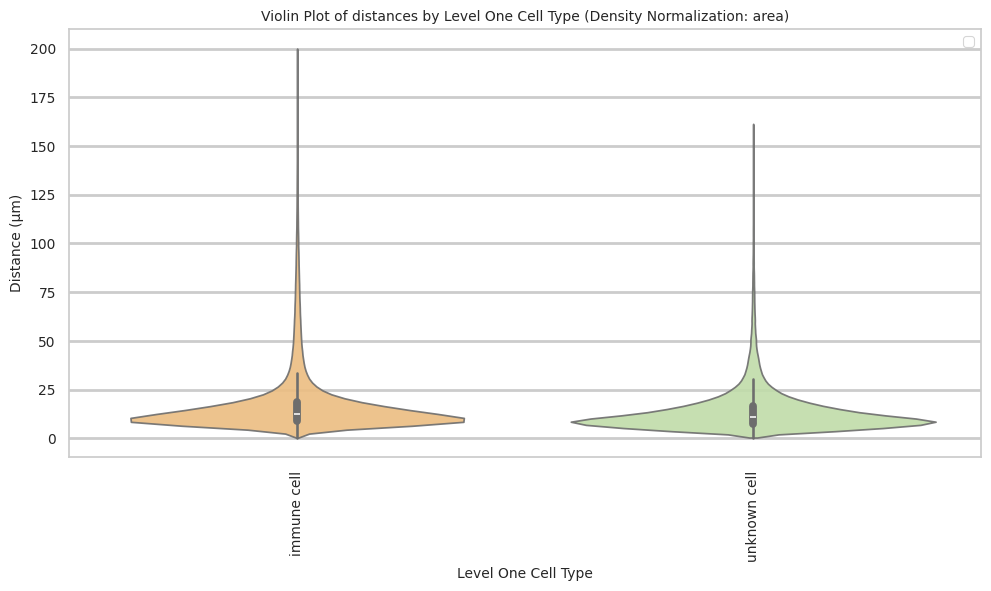

In [28]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

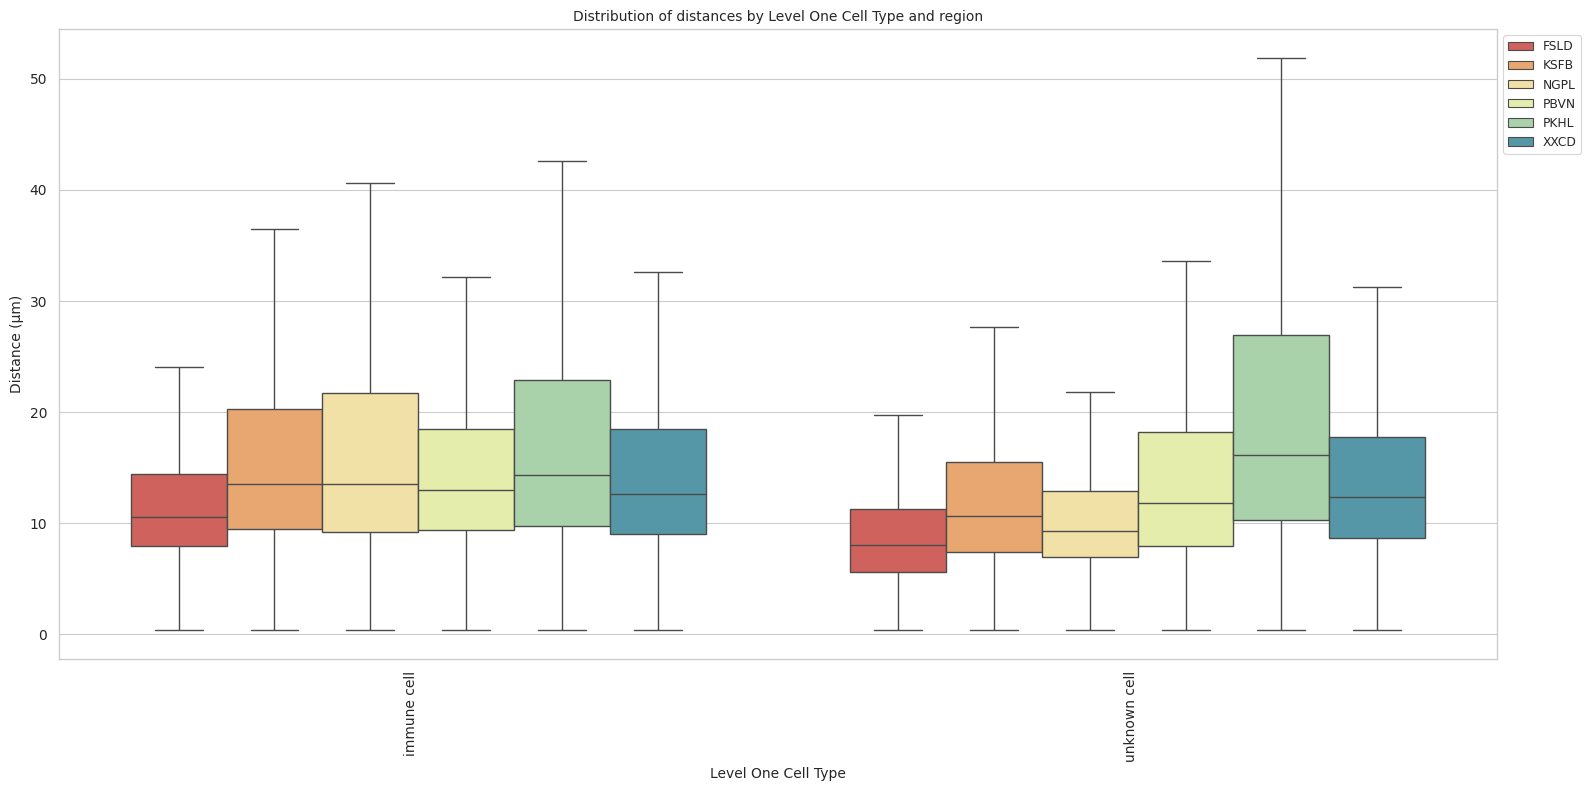

In [29]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

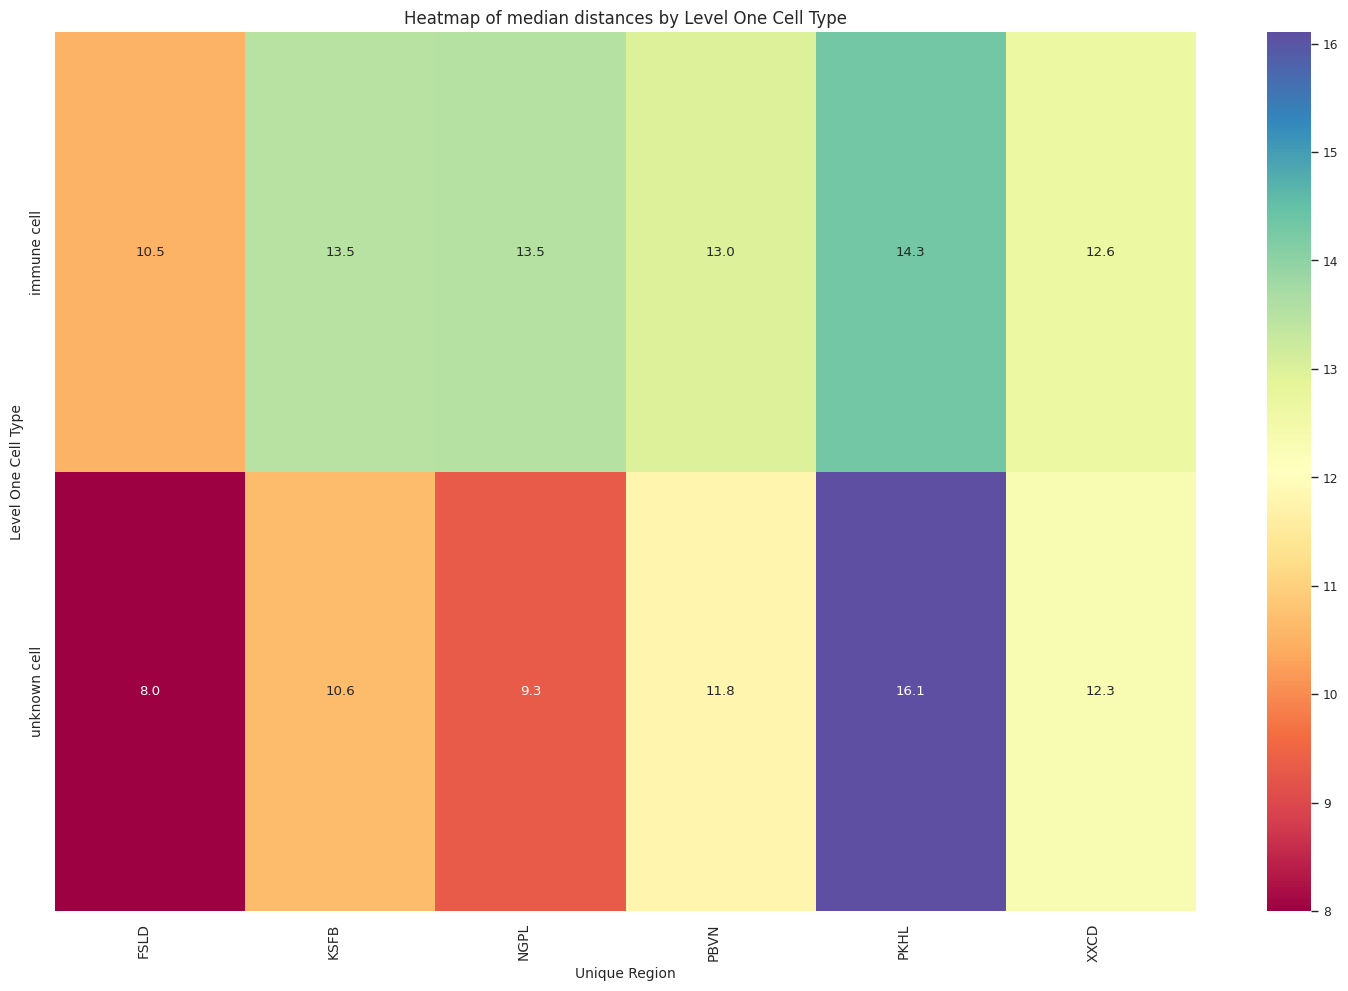

In [30]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

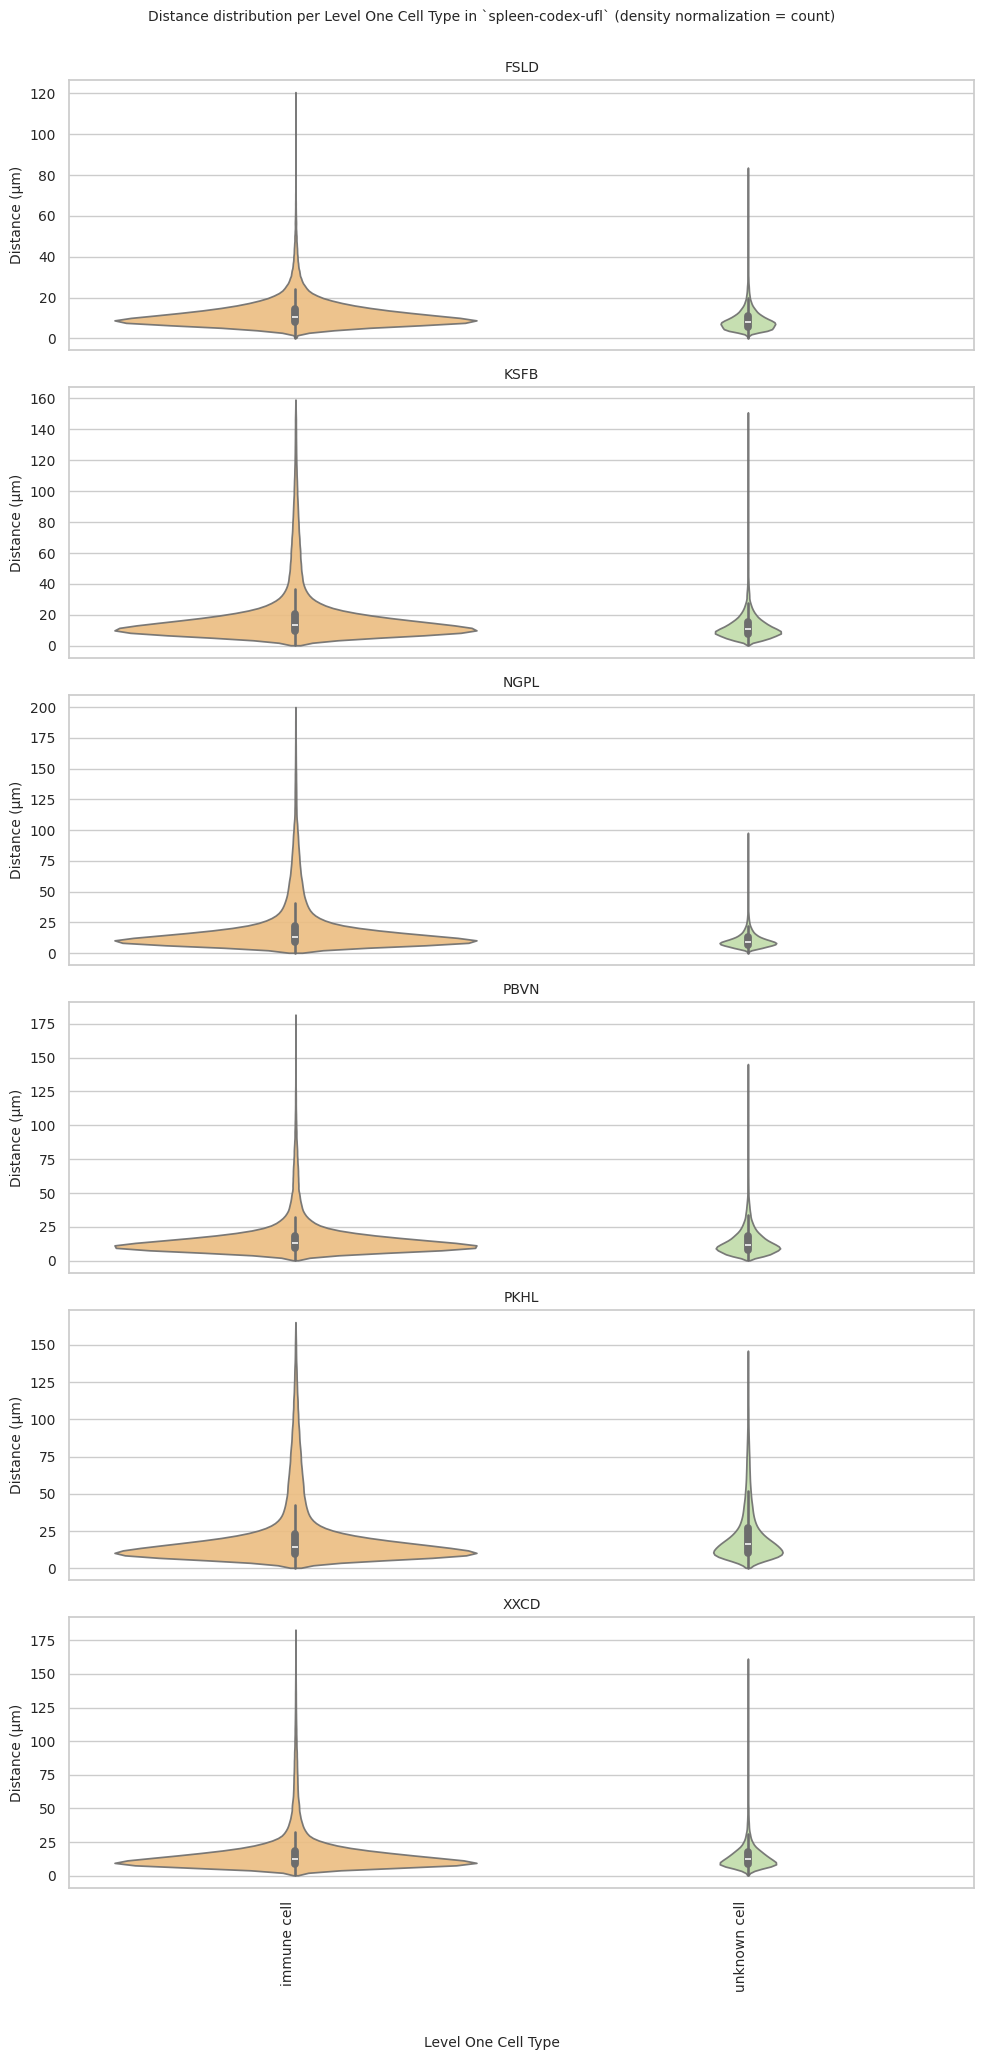

In [31]:
# Generate Violin Plot per unique region.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    font_size = 10
    fig, axs = plt.subplots(6, 1, figsize=(10, 20)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [32]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,b cell,FSLD,28.793129,18.193912,0.377000,174.062170
1,b cell,KSFB,66.936676,47.283075,0.533159,199.992015
2,b cell,NGPL,62.721335,50.108392,0.377000,199.946882
3,b cell,PBVN,43.296183,27.544230,0.377000,199.993437
4,b cell,PKHL,74.037735,63.134837,0.533159,199.996635
5,b cell,XXCD,60.047765,41.497409,0.533159,199.913826
6,endothelial cell of lymphatic vessel,FSLD,29.642101,22.399004,1.685995,170.821358
7,endothelial cell of lymphatic vessel,KSFB,61.887568,50.581903,3.243077,199.493211
8,endothelial cell of lymphatic vessel,NGPL,43.458134,39.208000,2.871146,198.593137
9,endothelial cell of lymphatic vessel,PBVN,32.893007,27.726806,3.039471,136.266075


In [33]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in FSLD:
                    Level Two Cell Type  mean_distance
1  endothelial cell of lymphatic vessel      29.642101
0                                b cell      28.793129
2     endothelial cell of vascular tree      21.913759
6                                t cell      19.170687
5                            neutrophil      13.274293

Bottom 5 cell types in FSLD:
  Level Two Cell Type  mean_distance
6              t cell      19.170687
5          neutrophil      13.274293
3          macrophage      12.964001
4        myeloid cell      12.219064
7        unknown cell      11.225060

Top 5 cell types in KSFB:
                    Level Two Cell Type  mean_distance
0                                b cell      66.936676
1  endothelial cell of lymphatic vessel      61.887568
6                                t cell      37.426450
2     endothelial cell of vascular tree      29.505573
7                          unknown cell      20.793916

Bottom 5 cell types in KSFB:
    

In [34]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in FSLD:
                    Level Two Cell Type  median_distance
1  endothelial cell of lymphatic vessel        22.399004
2     endothelial cell of vascular tree        20.119229
0                                b cell        18.193912
6                                t cell        13.723007
3                            macrophage        11.638253

Bottom 5 cell types in FSLD:
  Level Two Cell Type  median_distance
6              t cell        13.723007
3          macrophage        11.638253
5          neutrophil        10.616416
4        myeloid cell        10.122992
7        unknown cell         8.328202

Top 5 cell types in KSFB:
                    Level Two Cell Type  median_distance
1  endothelial cell of lymphatic vessel        50.581903
0                                b cell        47.283075
2     endothelial cell of vascular tree        23.603934
6                                t cell        20.902262
3                            macrophage        16.00363

In [35]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
FSLD           17.76  17.69    99.6
KSFB           32.30  37.95   117.5
NGPL           32.17  35.55   110.5
PBVN           24.70  24.92   100.9
PKHL           32.27  36.56   113.3
XXCD           24.94  29.75   119.3

Cell Type Variability Analysis (sorted by CV):
                                       mean    std  CV (%)
Level Two Cell Type                                       
unknown cell                          19.98  22.82   114.2
t cell                                27.79  30.32   109.1
b cell                                54.90  48.74    88.8
neutrophil                            15.81  13.10    82.9
myeloid cell                          15.79  12.86    81.4
endothelial cell of lymphatic vessel  42.11  30.14    71.6
macrophage                            

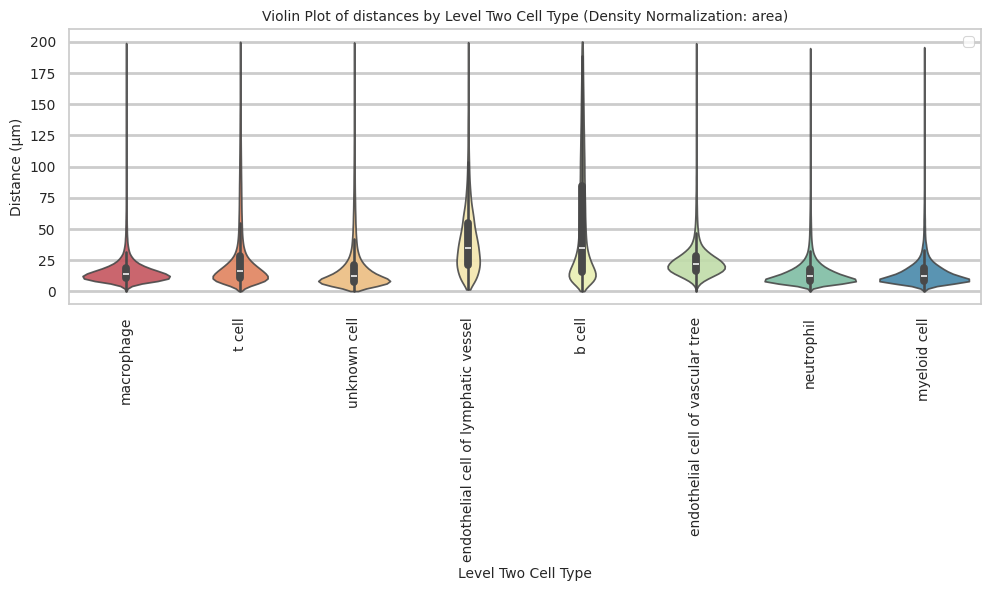

In [36]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

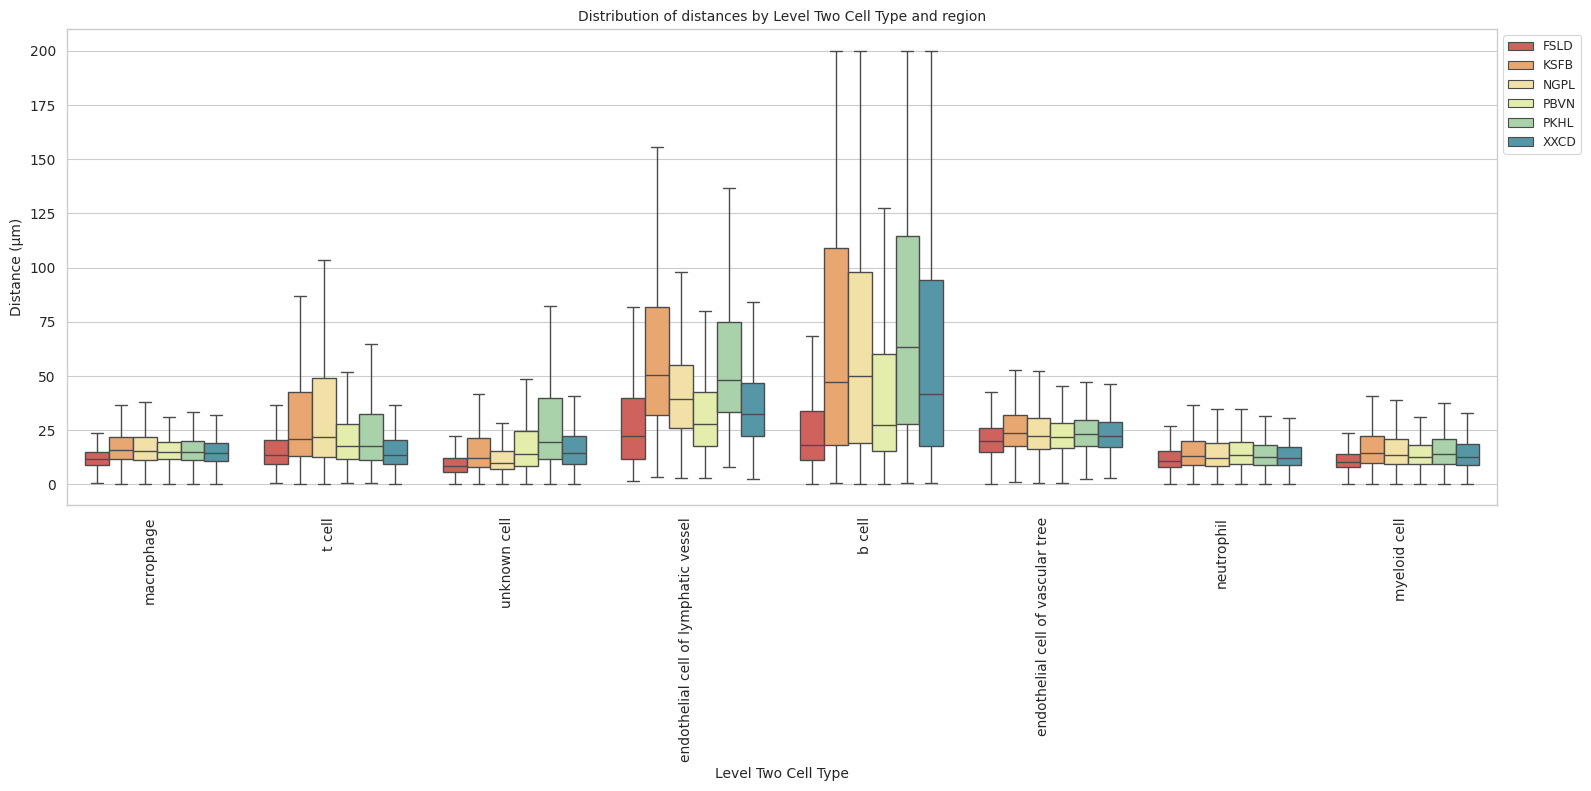

In [37]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

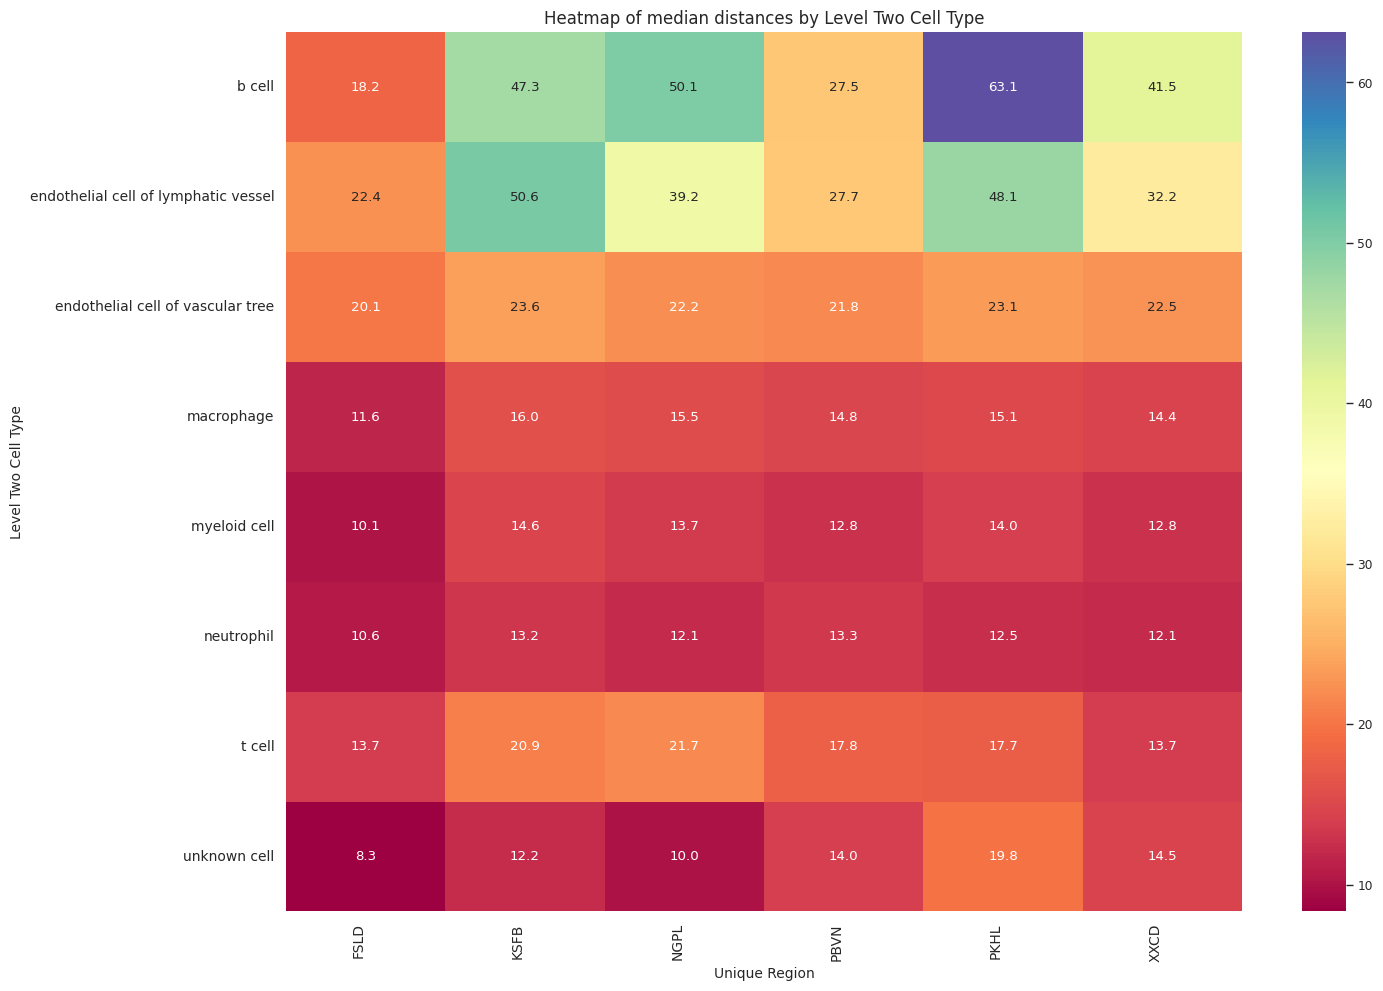

In [38]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

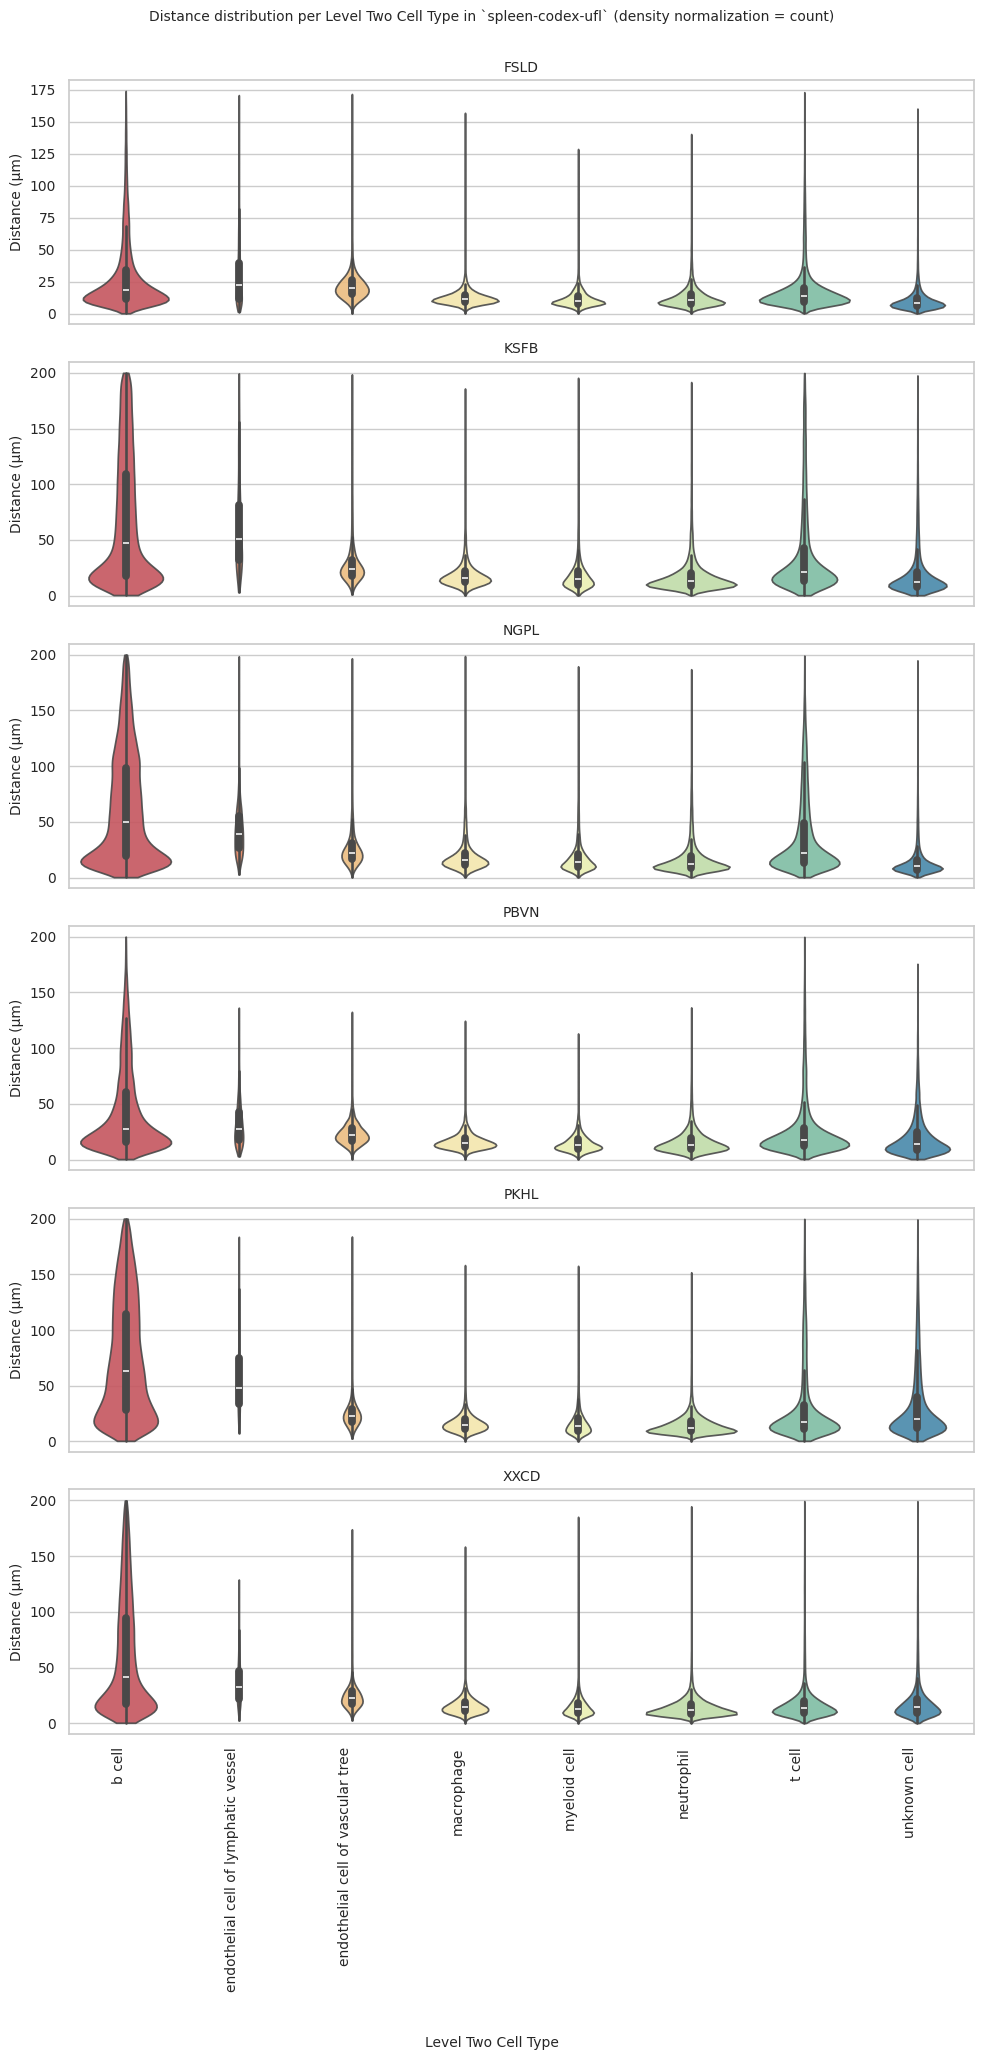

In [39]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

### Level Three Cell Type Analysis

In [40]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,b cell,FSLD,15.017328,12.756869,0.377000,150.453233
1,b cell,KSFB,21.320057,16.424398,0.533159,191.699959
2,b cell,NGPL,21.343961,15.945808,0.377000,197.501949
3,b cell,PBVN,18.469944,15.530387,0.377000,167.593356
4,b cell,PKHL,18.087155,14.218947,0.533159,156.409572
5,b cell,XXCD,16.399071,13.592928,0.533159,147.880623
6,b cell:follicular,FSLD,44.741041,33.688278,0.533159,174.062170
7,b cell:follicular,KSFB,98.262190,94.780079,3.016000,199.992015
8,b cell:follicular,NGPL,86.597350,82.378598,0.533159,199.946882
9,b cell:follicular,PBVN,62.807603,52.209394,3.221089,199.993437


In [41]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in FSLD:
                  Level Three Cell Type  mean_distance
1                     b cell:follicular      44.741041
8         t cell:cd4+ alpha-beta memory      30.214247
3  endothelial cell of lymphatic vessel      29.642101
4     endothelial cell of vascular tree      21.913759
2                    cell:proliferating      18.250368

Bottom 5 cell types in FSLD:
            Level Three Cell Type  mean_distance
9   t cell:cd8+ alpha-beta memory      13.932302
7             neutrophil/monocyte      13.274293
5                      macrophage      12.964001
6                    myeloid cell      12.219064
10                   unknown cell       9.064110

Top 5 cell types in KSFB:
                   Level Three Cell Type  mean_distance
1                      b cell:follicular      98.262190
3   endothelial cell of lymphatic vessel      61.887568
8          t cell:cd4+ alpha-beta memory      59.324035
4      endothelial cell of vascular tree      29.505573
10          

In [42]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in FSLD:
                  Level Three Cell Type  median_distance
1                     b cell:follicular        33.688278
3  endothelial cell of lymphatic vessel        22.399004
4     endothelial cell of vascular tree        20.119229
8         t cell:cd4+ alpha-beta memory        19.784420
2                    cell:proliferating        13.070542

Bottom 5 cell types in FSLD:
            Level Three Cell Type  median_distance
9   t cell:cd8+ alpha-beta memory        12.169569
5                      macrophage        11.638253
7             neutrophil/monocyte        10.616416
6                    myeloid cell        10.122992
10                   unknown cell         7.511672

Top 5 cell types in KSFB:
                  Level Three Cell Type  median_distance
1                     b cell:follicular        94.780079
3  endothelial cell of lymphatic vessel        50.581903
8         t cell:cd4+ alpha-beta memory        41.748388
4     endothelial cell of vascular tree 

In [43]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
FSLD           17.76  17.69    99.6
KSFB           32.30  37.95   117.5
NGPL           32.17  35.55   110.5
PBVN           24.70  24.92   100.9
PKHL           32.27  36.56   113.3
XXCD           24.94  29.75   119.3

Cell Type Variability Analysis (sorted by CV):
                                       mean    std  CV (%)
Level Three Cell Type                                     
unknown cell                          21.03  25.66   122.0
cell:proliferating                    18.51  18.05    97.5
t cell:cd4+ alpha-beta memory         47.75  40.36    84.5
neutrophil/monocyte                   15.81  13.10    82.9
myeloid cell                          15.79  12.86    81.4
b cell                                18.27  14.68    80.4
t cell:cd8+ alpha-beta memory         

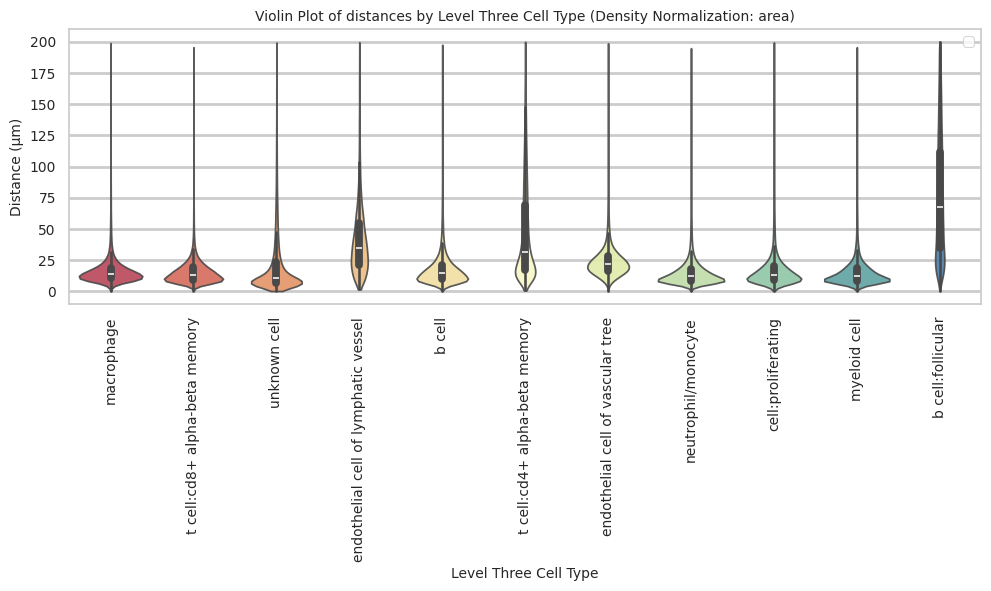

In [44]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

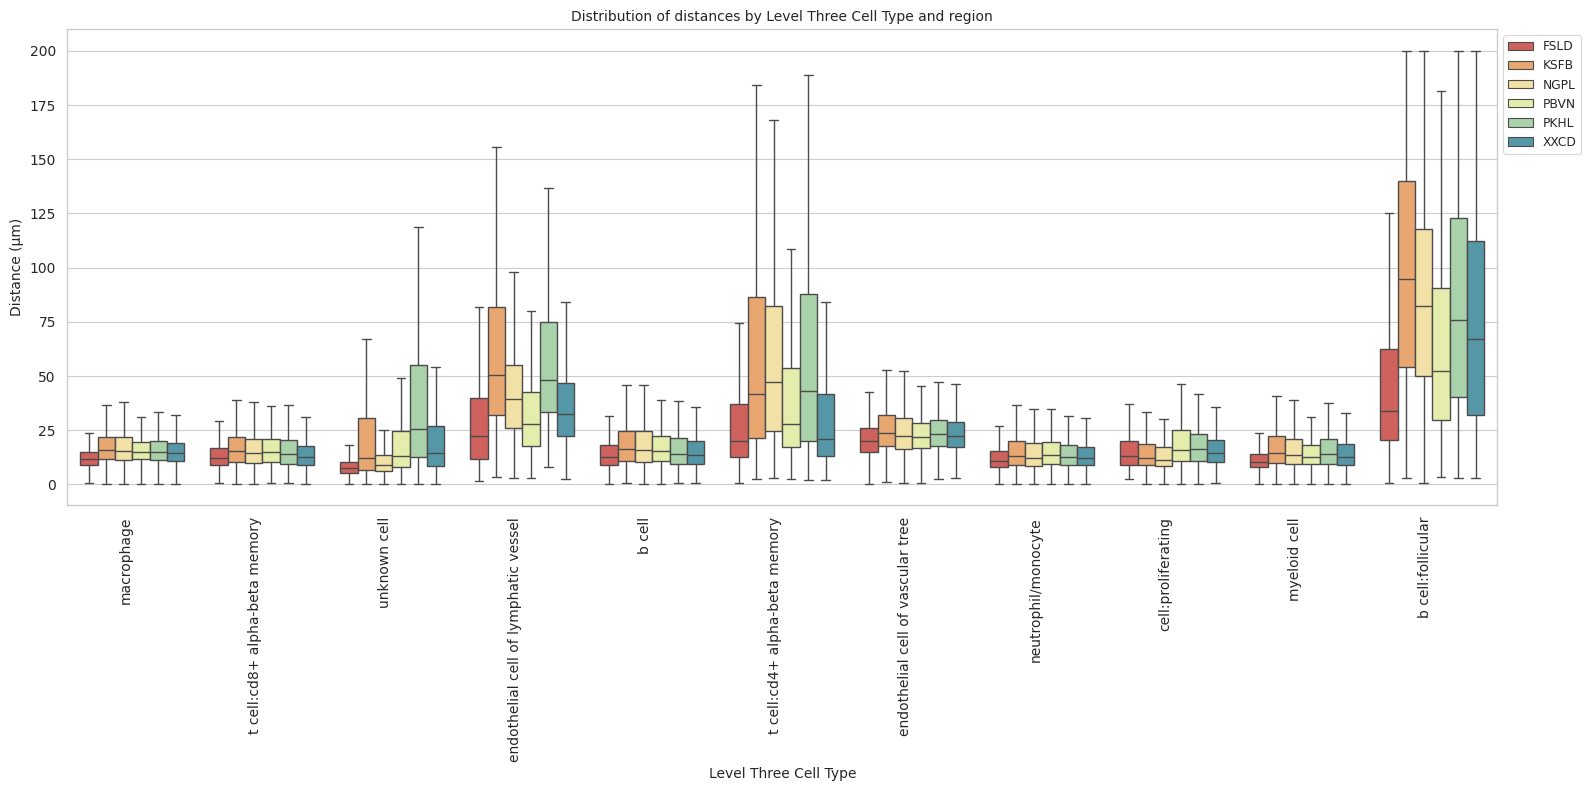

In [45]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

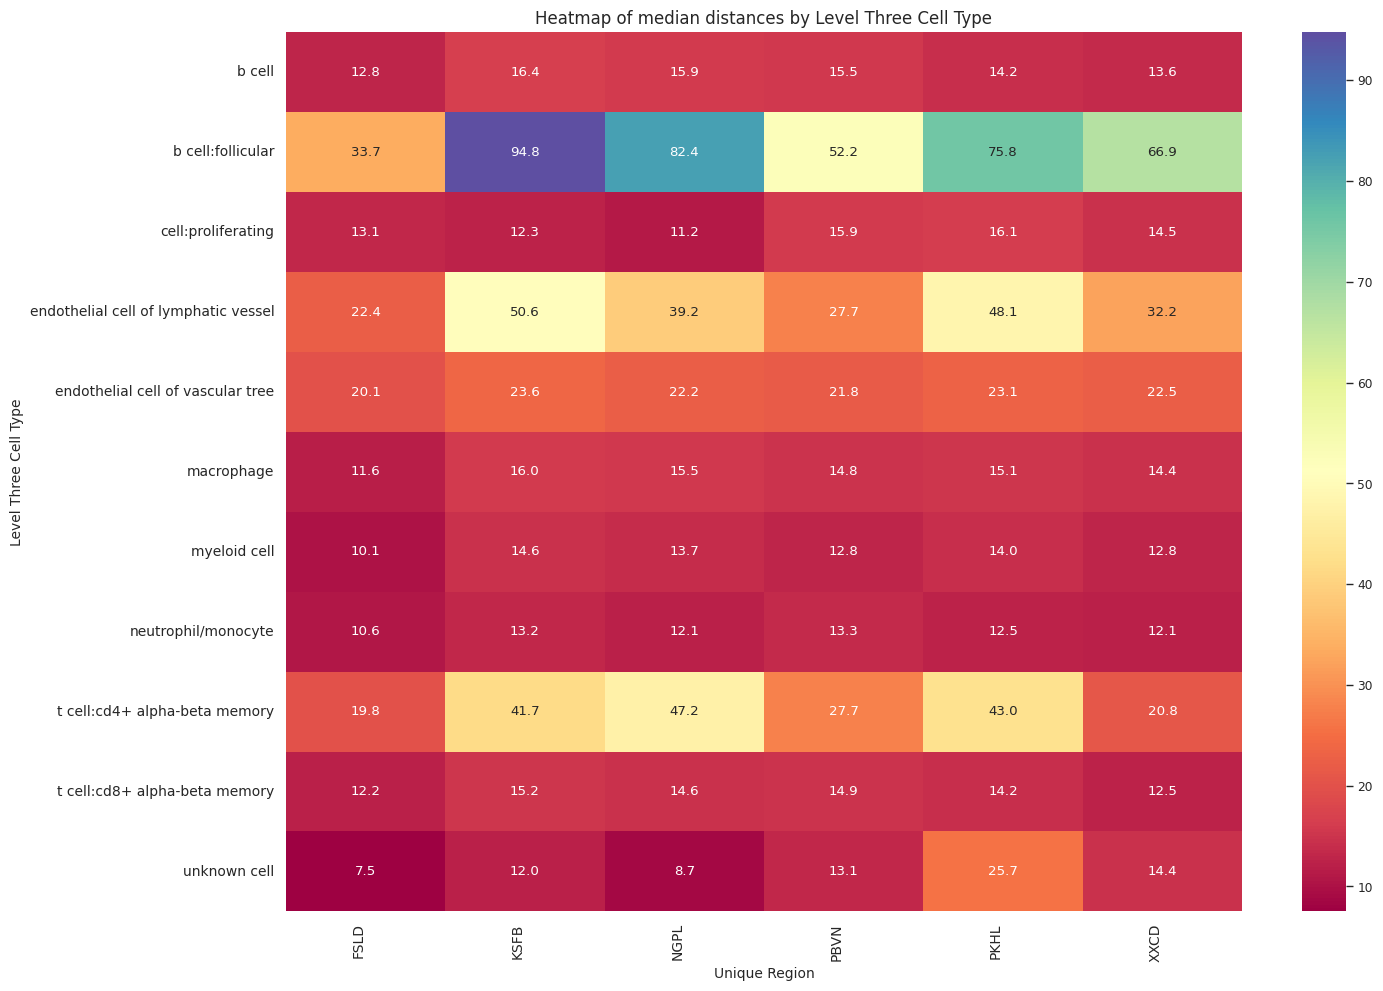

In [46]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

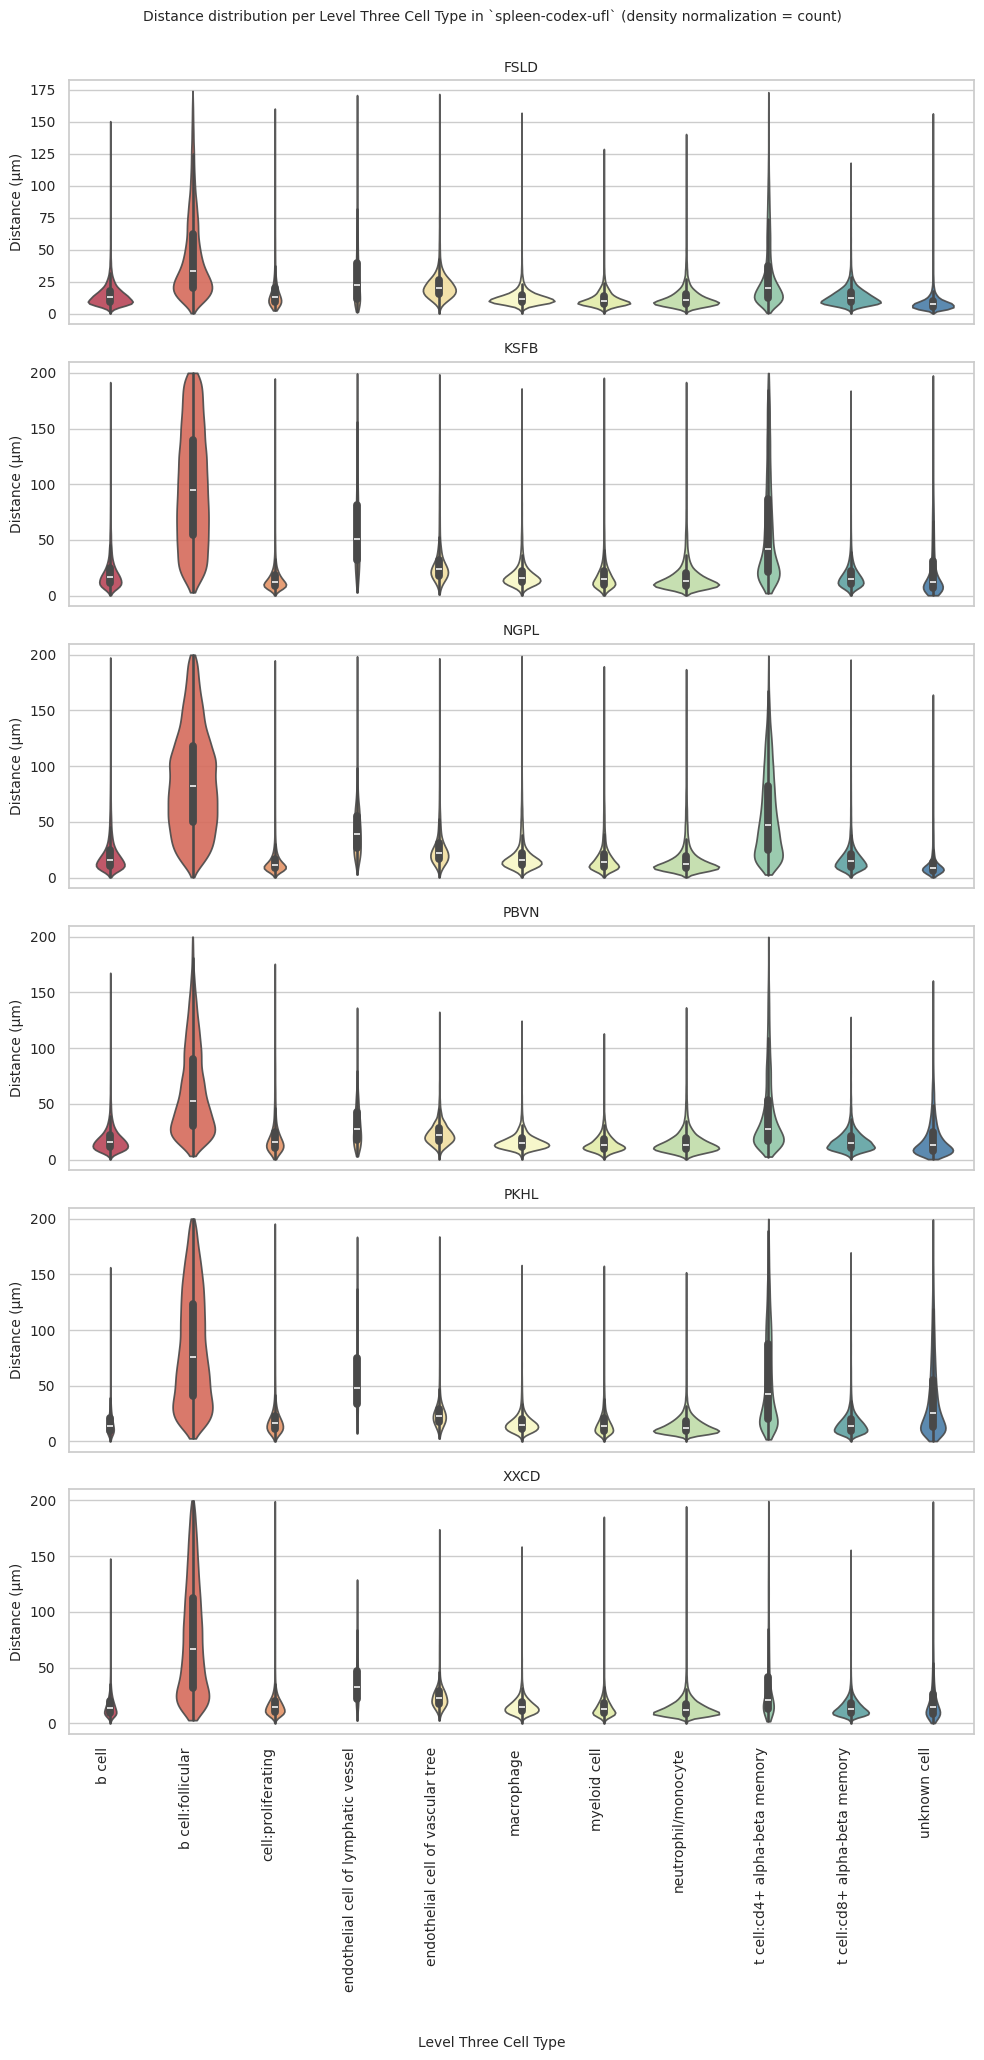

In [47]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.